In [23]:
import sqlite3
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import RebapFunctions as fnc
# import DBFunctions as db
sys.path.append(os.path.abspath(os.path.join(os.path.abspath(os.path.join(os.getcwd(), os.pardir)), os.pardir)))
import _Data.PredictionDataBase.DBFunctions as db
%matplotlib inline


In [24]:
# SRL = db.GetSRL4s()
SRL = db.GetSRL4s('C:\\Users\\henri\\source\\repos\\mozubi_tools\\_Analysis\\Rebap\\Data\\SRL_Bedarf_2015.csv')
TDS = db.GetTendersFromCsv('C:\\Users\\henri\\source\\repos\\mozubi_tools\\_Analysis\\Rebap\\Data\\\\RESULT_LIST_ANONYM_aFRR_2015.csv')

In [25]:
tStart = dt.datetime(2015,3,28,0,0,0)
tEnd = dt.datetime(2015,3,30,0,0,0)
SRL = SRL.loc[tStart:tEnd].dropna()
deltaT = tEnd-tStart

In [26]:
qhMaxPos = []
qhMinNeg = []
volumeNeg = []
volumePos = []
time = []
totalQh = np.int(deltaT.total_seconds()/900)

for qh in range(0,totalQh):
    t1 = tStart + dt.timedelta(minutes=15*qh)
    t2 = t1+dt.timedelta(minutes=15)
    srl = SRL.loc[t1:].loc[:t2].dropna().reset_index(drop=True)
    time.append(t1)
    volumeNeg.append(srl.Power.where(srl.Power <=0).sum()/900)
    volumePos.append(srl.Power.where(srl.Power > 0).sum()/900)
    qhMaxPos.append(srl.Power.max())
    qhMinNeg.append(srl.Power.min())

In [27]:
maxSRL = pd.DataFrame(np.array([time,qhMaxPos,qhMinNeg,volumePos, volumeNeg]).transpose(),columns=['TimeStamp','P_qh_max','P_qh_min','VolumePOS','VolumeNEG'])
maxSRL.P_qh_max = pd.to_numeric(maxSRL.P_qh_max)
maxSRL.P_qh_min = pd.to_numeric(maxSRL.P_qh_min)
maxSRL.VolumeNEG = pd.to_numeric(maxSRL.VolumeNEG)
maxSRL.VolumePOS = pd.to_numeric(maxSRL.VolumePOS)
maxSRL = maxSRL.interpolate(method='pchip',limit=4)

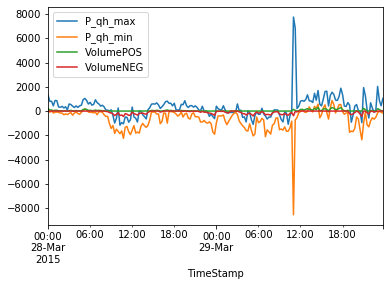

In [28]:
maxSRL.set_index('TimeStamp').plot()

In [29]:
APMAXpn = []
time = []

for i in range(0,len(maxSRL)):
    time.append(maxSRL.TimeStamp[i])
    td = fnc.GetTender(TDS,maxSRL.TimeStamp[i])
    mols = fnc.GetMOLsForTender(td,maxSRL.TimeStamp[i])

    apPmax = fnc.GetAPmaxFromMOL(maxSRL.P_qh_max[i],mols,fnc.GetProduct(maxSRL.TimeStamp[i], maxSRL.P_qh_max[i] >= 0))
    apPmin = fnc.GetAPmaxFromMOL(maxSRL.P_qh_min[i],mols,fnc.GetProduct(maxSRL.TimeStamp[i], maxSRL.P_qh_min[i] >= 0))

    APMAXpn.append([apPmax,apPmin])

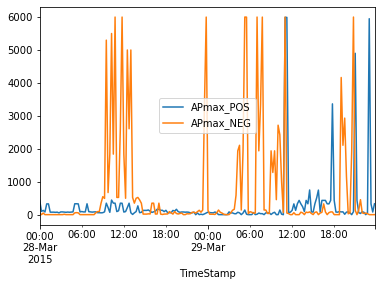

In [30]:
APMAXpn = np.array(APMAXpn)
APMAXpn = pd.DataFrame(np.array([time,APMAXpn[:,0],APMAXpn[:,1]]).transpose(),columns=['TimeStamp','APmax_POS','APmax_NEG'])
APMAXpn['APmax_POS'] = pd.to_numeric(APMAXpn['APmax_POS'])
APMAXpn['APmax_NEG'] = pd.to_numeric(APMAXpn['APmax_NEG'])
APMAXpn.set_index('TimeStamp').plot()

In [31]:
apmax = []

for i in range(0,len(APMAXpn)):
    apmax.append(max(np.absolute(APMAXpn.APmax_POS[i]),np.absolute(APMAXpn.APmax_NEG[i])))

APMAX = pd.DataFrame(np.array([time,apmax,maxSRL.VolumeNEG.values,maxSRL.VolumePOS.values]).transpose(),columns=['TimeStamp','APmax','VolumeNEG','VolumePOS'])
APMAX['APmax'] = pd.to_numeric(APMAX['APmax'])


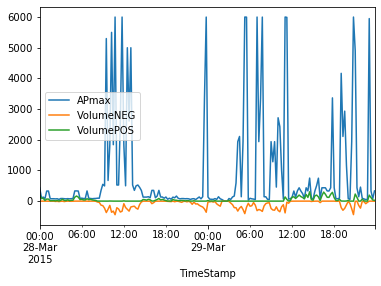

In [32]:
APMAX.set_index('TimeStamp').plot()

In [33]:
# APMAX.set_index('TimeStamp').to_csv(db.datapath+'\\APMAX2.csv', decimal='.',sep=';')